In [1]:
using StatsBase
using CircularArrays
using LinearAlgebra
using Plots
using Random

In [2]:
#Define the parameters n, L(n), t, Ne(L)

n = 7
L = 8*n + 4
t = 1
Ne = Int(L / 2)

30

In [3]:
#Here we define the hamiltonian and the states - Lstate (length L with +1 -1 0 and 2 as occupancies)
#as well as the conversion between states from L to the extended one of 2L and viceversa

function Hamiltonian(L,t)
    H = zeros(2*L, 2*L)
    H[1,L] = -t
    H[L,1] = -t
    H[2L,L+1] = -t
    H[L+1,2L] = -t
    for i=1:2*L
      for j=1:2*L
        if i == j + 1 || i == j - 1
          H[i,j] = -t
        end 
      end
    end
    H[L,L+1]=0
    H[L+1,L]=0
    return H
end

H = Hamiltonian(L,t);


#generate, convert state
function Lstate(L)                                 #generate a state of length L
    Lstated, Lstateu, Lstate = zeros(L), zeros(L), zeros(L)
    randomposu = sample(collect(1:L), Int(L/4), replace=false)
    randomposd = sample(collect(1:L), Int(L/4), replace=false)
    for j in randomposu
        Lstateu[j] = 1
    end
    for j in randomposd
        Lstated[j] = -1
    end
    for i=1:L 
        if Lstated[i] == -1 && Lstateu[i] == 1
            Lstate[i] = 2
        else
            Lstate[i] = Lstated[i] + Lstateu[i]
        end
    end
    return CircularArray(Lstate)
end


function extendedstate(Lstatevector)               #take a state of length L and make it 2*L
    L = length(Lstatevector)
    State2L = zeros(2*L)
    for j=1:L
        if Lstatevector[j] == -1
            State2L[j + L] = 1
        elseif Lstatevector[j] == 1
            State2L[j] = 1
        elseif Lstatevector[j] == 2
            State2L[j], State2L[j + L] = 1,1
        else
            State2L[j] = 0
        end
    end
    return CircularArray(State2L)
end


function shortstate(ext_state)                    #pass trom 2*L state to L state
    L = Int(length(ext_state)/2)
    sh_state = zeros(L)
    for j=1:L
        if ext_state[j]==1
            sh_state[j]=1
        end
    end
    for j=1:L
        if ext_state[L+j]==1
            if sh_state[j]==1
                sh_state[j]=2
            else
                sh_state[j]=-1
            end
        end
    end
    return sh_state
end

shortstate (generic function with 1 method)

In [4]:
#In this section we define functions to found the occupied and empty sites in our state and the move - hopping functions
#There are 3 options for the move, move_L and hopping makes a hop in vectors of length L and move_last_2L with ones  

#generate a move
function Pauli(x,i,j)                 #check if state i and j are both occupied
    if x[i] == 1 && x[j] == 1
        return true
    end
    return false
end 

function occupied_states(v)         #generate a vector with positions of occupied states (from 2*L states)
    occ_states = []
    L = length(v)
    for i = 1:L
        if v[i] == 1
            append!(occ_states, i)
        end
    end
    return occ_states
end


function occupied_states_L(v)
    occ_states = []
    L =length(v)
    for i = 1 : L
        if abs(v[i]) == 1
            append!(occ_states, i )
            
        elseif v[i] == 2
            append!(occ_states, i )
        
        end
    end
    return occ_states
end

function empty_states(v)
    empty_st_u = []
    empty_st_d = []
    L = length(v)
    for i = 1 : Int(L/2)
        if v[i] == 0
               append!(empty_st_u, i )
        end
    end
    for i = Int(L/2)+1 : L
        if v[i] == 0
               append!(empty_st_d, i )
        end
    end
    return empty_st_u, empty_st_d
end

function move_L(w)
    
   v = copy(w)
   i = rand(occupied_states_L(v))
   j = rand(-1:2:1)

    j_pbc = mod(i+j,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

    if v[i] != v[j_pbc] && v[j_pbc]!=2

        if abs(v[i])==1
            v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2
            v[i] = 0

        elseif v[i]==2    
            spin = rand(-1:2:1)

        if v[j_pbc] != spin
           v[i] = -spin

        if abs(v[j_pbc]) == 1 
            v[j_pbc] = 2 
        elseif v[j_pbc] == 0 
            v[j_pbc] = spin 
        end

        end    
        end
            
    end

    return v
    
end

function move_last_2L(w)
    v = copy(w)
    L = length(v)
    i = rand(occupied_states(v))
    if i < L+1 
        j = rand(empty_states(v)[1])
        v[j] = v[i]
    else 
        j = rand(empty_states(v)[2])
    end
    v[i] = 0
    b = shortstate(v)
    return b
end

function hopping(v)
    w = copy(v)
    occupied_positions = occupied_states_L(v)
    i = rand(occupied_positions)
    nn = [v[i + 1],v[i - 1]]
    nnpos = [i + 1, i - 1]
    rndnnpos = rand([i + 1,i - 1])
    rndnn = rand(nn)
    
    if nn[1] == 2 && nn[2] == 2 || v[i] == 1 && nn[1] == 1 && nn[2] == 2 || v[i] == 1 && nn[1] == 2 && nn[2] == 1 || v[i] == 1 && nn[1] == 1 && nn[2] == 1 || v[i] == -1 && nn[1] == -1 && nn[2] == 2 || v[i] == -1 && nn[1] == 2 && nn[2] == -1 || v[i] == -1 && nn[1] == -1 && nn[2] == -1
        i = rand(deleteat!(occupied_positions, findall(x->x==i,occupied_positions)))
    end
    
    if v[i] == 1 && v[rndnnpos] == 1 || v[i] == 1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == -1 && v[rndnnpos] == -1 || v[i] == -1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == 2 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
     
    if v[i] == 1
        if v[rndnnpos] == -1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, 1
        end
    
    elseif v[i] == -1 
        if v[rndnnpos] == 1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, -1
        end
    
    elseif v[i] == 2
        if v[rndnnpos] == 1 
            w[i], w[rndnnpos] = 1, 2
        elseif v[rndnnpos] == -1
            w[i], w[rndnnpos] = -1,2
        elseif v[rndnnpos] == 0
            choosenspin = rand([1,-1])
            w[i], w[rndnnpos] = -1*choosenspin, choosenspin
        end
    end
    
    return w
end

hopping (generic function with 1 method)

In [5]:
#generate unitary matrices and the ratio of determinants

U = eigvecs(H)  #unitary matrix
Udag = inv(U)   #U^-1
E = eigvals(H)  #eigenvalues of H

function U1(A, Ne) #take the first Ne columns
    U_1 = A[:,1:Ne]
    return U_1
end

U_1 = U1(U,Ne)

function U_tilde(A,v)                  #takes just the rows related to occupied states, Ne*Ne matrix
    U_tild = []
    U_tild = A[occupied_states(v),:]
    return U_tild
end

function ratio_det(v, z)
    rat= det(U_tilde(U_1,z))/det(U_tilde(U_1,v))
    return rat
end  


ratio_det (generic function with 1 method)

In [6]:
#Jastrow factor
function n_i(vi)           #counts the number of els in positions vi, returning (# up , # down)
    
    n_up = 0
    n_down = 0
    
        if vi == 1
            n_up += 1
            
        elseif vi == -1
            n_down += 1
                
        elseif vi == 2
            n_down += 1
            n_up += 1
                
        end

return n_up, n_down

end

function Jastrow(state,g,v)
            
    D=length(state)       
    
    Spins=0
    Occupancies=0  
    
   # n1 = n_i(state[D])[1] + n_i(state[D])[2]
    n2 = 0
    
    for i = 1 : D     
            
    j_pbc = mod(L+i+1,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc
                
        n_up= n_i(state[i])[1]    
        n_down = n_i(state[i])[2]
                
    Spins = Spins + n_up*n_down 
                
    n1= n_up + n_down
        
    n_up= n_i(state[j_pbc])[1]    
    n_down = n_i(state[j_pbc])[2]
    
     n2= n_up + n_down
        
    n1n2 = n1*n2   
    n1 = n2
                
    Occupancies = Occupancies + n1n2
            
        end
    
    arg=  -g*Spins -v*Occupancies
            
return exp(arg)

end
#This function calculates the density observable in the odd sites A
function nA(v)
    nA = 0
    for j=1:length(v)
        if j%2 != 0
            nA += sum(n_i(v[j])) 
        end
    end
    return nA*2/length(v)
end

#This function calculates the density observable in the even sites B
function nB(v)
    nB = 0
    for j=1:length(v)
        if j%2 == 0
            nB += sum(n_i(v[j])) 
        end
    end
    return nB*2/length(v)
end

nB (generic function with 1 method)

In [19]:
function Block(v, Ne, Ni)
    
    Average_Bin = []
    
    N=length(v)
    
    Lbin = Ne
    
    Nbin = floor(Int,N/Lbin)
    
    a=0
    b=0
    
    for i in Ni:Nbin
       
    a = (i-1)*Lbin +1
    b = i*Lbin
        
av_bin = (1/Int(abs(Lbin)))*(sum(v[Int64(a):Int64(b)]))
        
push!(Average_Bin,av_bin)
        
    end

return Average_Bin, sum(Average_Bin)/(Nbin-Ni+1), Nbin

end

Block (generic function with 1 method)

In [24]:
function Error_Block(v, Ne, Ni)
    
    SD_Array = []

    Average_Bin, mean_, Nbin = Block(v, Ne, Ni)
    
    for i in 1:length(Average_Bin)

    av_bin = Average_Bin[i]-mean_
        
push!(SD_Array,av_bin^2 )
        
    end

return sqrt(mean(SD_Array))/sqrt(Nbin)
    
end


Error_Block (generic function with 1 method)

In [9]:
function orthogonal(w, i)
    v = copy(w)
    L = length(v)
    states = []
    J = [-1,1]
    
    for j in J
        
        v = copy(w)
    
        j_pbc = mod(i+j,L)
        j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

            if v[i] != v[j_pbc] && v[j_pbc]!=2

                if abs(v[i])==1
                v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2 
                v[i] = 0    
                push!(states,v)

                elseif v[i]==2    
                Spin = [-1,1]

                    for spin in Spin
                    v = copy(w)

                            if spin != v[j_pbc] && v[j_pbc]!=2
                                v[j_pbc] == 0 ? v[j_pbc] = spin : v[j_pbc] = 2 
                                v[i] = -spin
                                push!(states,v)
                            end  
                      end
                 end   
          end
        
    end 
    
    return states
    
end

orthogonal (generic function with 1 method)

In [42]:

#Monte Carlo simulation that calculates nA along the simulation
import Random

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    
    t=1
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    
    x_prime_L = CircularArray(zeros())
    x_prime_2L = CircularArray(zeros())
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = CircularArray(zeros())
    x_L = CircularArray(zeros())
    x_2L = CircularArray(zeros())
    state_new_2L = CircularArray(zeros())
    
    Suma_A = []
    Suma_B = []
    
    Pot= []
    
    EN = []
    
    k=0
    l=0
    
    for istep = 1:nsteps

        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = hopping(state_L)
            state_new_2L = extendedstate(state_new_L)

            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2
            
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                state_L = copy(state_new_L)
                state_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
        x_L = copy(state_new_L)
        x_2L = copy(state_new_2L)
        pot = log(Jastrow(x_L,-U,-V))
        #display(pot)
        
              e_n = 0
        
                 for i in occupied_states_L(x_L)
        
                 o_states = orthogonal(x_L, i)
            
                     for j in 1:length(o_states)
                        x_prime_L = o_states[j]
                        x_prime_2L = extendedstate(x_prime_L)   
                         Prob =  (ratio_det(x_2L,x_prime_2L)*((Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))))^2
                         acc = min(1,Prob)

                           if Prob<=1 && Prob>rand()   
                           local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))
 
                            
                            end
                             e_n += local_est
                    
                            
                     end      
                 end
   
           push!(EN,e_n)
        
           e_n += pot 
        
           push!(locals,e_n)
            
           push!(Pot,pot)
          end
    return  Block(locals,Int64(Ne/2),Int64(1))[2] , Error_Block(locals,Int64(Ne/2),Int64(1))
end

MC_pietro (generic function with 2 methods)

In [43]:
a = Lstate(L);
MC_pietro(a,10,2,30,5,100)

(-11.700866960213808, 5.151508811298229)

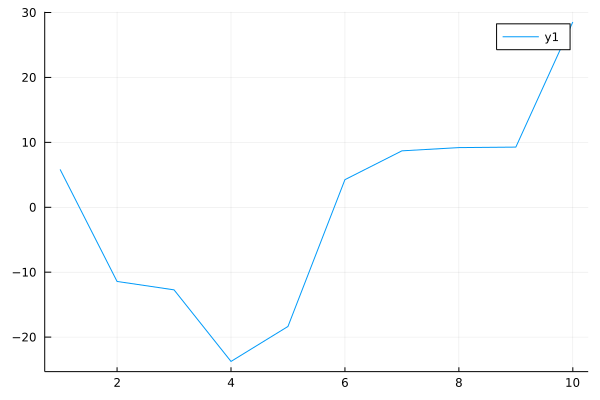

In [109]:
using Plots


x = collect(1:10)
#y = [MC_pietro(a,10,v,30,5,100)[1] for v in x]

plot(x,y)

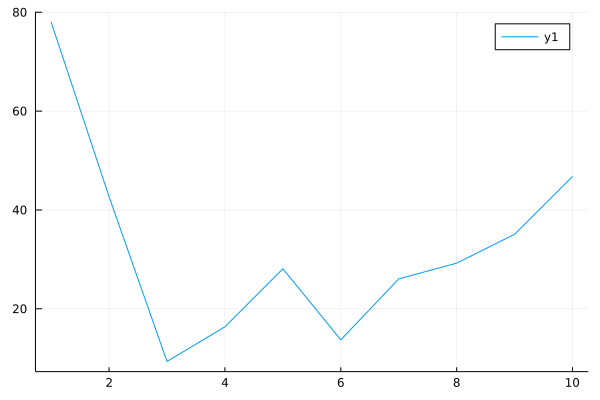

In [110]:
using Plots


x = collect(1:10)
#y = [MC_pietro(a,10,v,30,15,100)[1] for v in x]

plot(x,y_1)

In [102]:
x = collect(1:10)
exe = [MC_pietro(a,10,v,30,5,100) for v in x]
exe

10-element Vector{Tuple{Float64, Float64}}:
 (5.835572732128856, 2.5758919259768365)
 (-11.428091858959123, 3.9141870788410498)
 (-12.721022128526883, 5.759674985164449)
 (-23.746469691849786, 7.305561438761838)
 (-18.35681425636807, 6.852487729201062)
 (4.2571652953140555, 7.443578135968769)
 (8.693257691781714, 6.862946999540444)
 (9.192689159374856, 8.544469442596649)
 (9.269139223600476, 11.64644990770716)
 (28.541572461870526, 8.037916960617302)

In [104]:
y = []
for i in x
    append!(y,exe[i][1])
end
err = []
for i in x
    append!(err,exe[i][2])
end
err

10-element Vector{Any}:
  2.5758919259768365
  3.9141870788410498
  5.759674985164449
  7.305561438761838
  6.852487729201062
  7.443578135968769
  6.862946999540444
  8.544469442596649
 11.64644990770716
  8.037916960617302

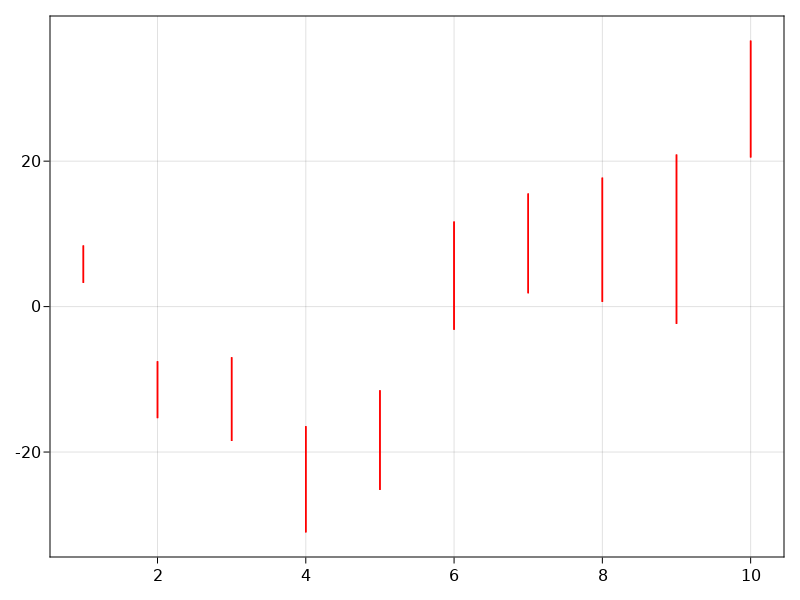

In [105]:
using CairoMakie



f = Figure()
Axis(f[1, 1])

x = collect(1:10)

lowerrors = -err 
higherrors = err

plot(x, y, markersize = 3, color = :black)
errorbars!(x, y, higherrors, color = :red) 

errorbars!(x, y, lowerrors, color = :red) # same low and high error
# plot position scatters so low and high errors can be discriminated


f

In [106]:
exe_1 = [MC_pietro(a,10,v,30,15,100) for v in x]

10-element Vector{Tuple{Float64, Float64}}:
 (78.03088204790183, 6.309984427052921)
 (42.70704642832025, 8.04060329874872)
 (9.350087071589238, 11.669886331966813)
 (16.359651393069818, 9.572303227090666)
 (28.101279561554644, 9.728501563985649)
 (13.722434163989599, 11.095868260718865)
 (26.056718873474846, 12.292995416320919)
 (29.241384151041718, 11.362683224084698)
 (35.08125405905586, 10.950845891707836)
 (46.7872249923586, 12.13132770958109)

In [107]:
y_1 = []
for i in x
    append!(y_1,exe_1[i][1])
end
err_1 = []
for i in x
    append!(err_1,exe_1[i][2])
end
err

10-element Vector{Any}:
  2.5758919259768365
  3.9141870788410498
  5.759674985164449
  7.305561438761838
  6.852487729201062
  7.443578135968769
  6.862946999540444
  8.544469442596649
 11.64644990770716
  8.037916960617302

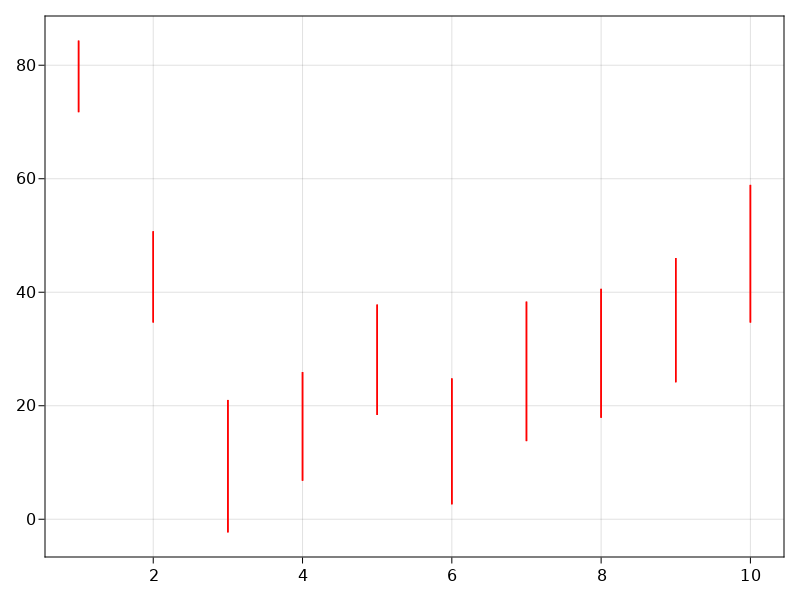

In [108]:
using CairoMakie



f = Figure()
Axis(f[1, 1])

x = collect(1:10)

lowerrors = -err_1 
higherrors = err_1

plot(x, y_1, markersize = 3, color = :black)
errorbars!(x, y_1, higherrors, color = :red) 

errorbars!(x, y_1, lowerrors, color = :red) # same low and high error
# plot position scatters so low and high errors can be discriminated


f